# Disease Predictor

This notebook implements a Multi-Label Text Classification model using Bert Preprocessor and Bert Encoders. The model in question will predict the disease a certain individiual may have based on the symptoms that he/she enters in text form.

# Importing Libraries

We are importing the required libraries now for preprocessing our data, building our model and saving our prediction classes.

TensorFlow (import tensorflow as tf): TensorFlow is an open-source machine learning library. It provides a comprehensive set of tools for building and deploying machine learning models. The tf alias is commonly used for convenience.

TensorFlow Hub (import tensorflow_hub as hub): TensorFlow Hub is a library for reusable machine learning modules. It allows you to share and reuse pre-trained models or model components. The hub alias is commonly used for convenience.

TensorFlow Text (import tensorflow_text as text): TensorFlow Text is an extension of TensorFlow that provides text processing capabilities, including preprocessing and tokenization for natural language processing (NLP) tasks.

Pandas (import pandas as pd): Pandas is a powerful data manipulation and analysis library for Python. It provides data structures like DataFrames, which are useful for handling and analyzing structured data.

Scikit-learn preprocessing (import sklearn.preprocessing): Scikit-learn is a machine learning library for various tasks, and sklearn.preprocessing provides functions for preprocessing data, such as scaling and encoding.

JSON (import json): JSON (JavaScript Object Notation) is a lightweight data interchange format. The json module in Python is used for encoding and decoding JSON data.

Warnings (import warnings): The warnings module is used to handle warning messages in Python. It allows you to control whether warnings are shown, ignore them, or turn them into exceptions.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import sklearn.preprocessing
import json
import warnings

In [ ]:
warnings.filterwarnings('ignore')

# Defining Hyperparameters

We are defining the number of epochs our model will train and the size of the batches our data will be split into.

EPOCHS (EPOCHS = 8):
Represents the number of complete passes through the training dataset during model training.
Set to 8, indicating the model will iterate through the dataset 8 times.

BATCH_SIZE (BATCH_SIZE = 64):
Represents the number of training examples processed in one iteration during training.
Set to 64, meaning the model will process 64 examples at a time.

In [ ]:
EPOCHS = 8
BATCH_SIZE = 64

# Importing & Cleaning our Data

We now import the csv file as a pandas DataFrame and then begin cleaning our data to prepare it for training.

import pandas as pd: Imports the Pandas library and aliases it as 'pd'.

df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv'): Reads a CSV file located at the specified path and assigns the DataFrame to the variable 'df'.

df.drop('Unnamed: 0', axis='columns', inplace=True): Drops the column named 'Unnamed: 0' from the DataFrame in-place.

df['label'] = df['label'].apply(lambda x: x.title()): Applies the title() function to each element in the 'label' column, converting the first character of each word to uppercase.

df.head(2): Displays the first two rows of the modified DataFrame.

In [ ]:
df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df['label'] = df['label'].apply(lambda x: x.title())
df.head(2)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."


## One hot encoding the target labels

We now one hot encode the target labels since the labels are in string categorical format and so we convert it to one hot encoded format to make it suitable for training.

Label Binarization:

A LabelBinarizer object from scikit-learn is created. This object is used to transform categorical labels into a binary matrix (one-hot encoding).
Transformation and Joining:

The fit_transform method of the LabelBinarizer is applied to the 'label' column of the DataFrame (df).
The resulting binary matrix is converted into a DataFrame with appropriate column names and the original DataFrame's index.
This new binary-encoded DataFrame is then joined with the original DataFrame based on the index.
Drop Original Column:

The original 'label' column is dropped from the DataFrame since it has been replaced by the binary-encoded columns.

In [ ]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
df = df.join(pd.DataFrame(label_binarizer.fit_transform(df['label']),
                         columns=label_binarizer.classes_,
                         index=df.index
                         ))
df.drop('label', axis='columns', inplace=True)
df.head(2)

,text,Acne,Allergy,Arthritis,Bronchial Asthma,Cervical Spondylosis,Chicken Pox,Common Cold,Dengue,Diabetes,...,Impetigo,Jaundice,Malaria,Migraine,Peptic Ulcer Disease,Pneumonia,Psoriasis,Typhoid,Urinary Tract Infection,Varicose Veins
0,I have been experiencing a skin rash on my arm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"My skin has been peeling, especially on my kne...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Preparing Training & Validation Datasets

The next step is to split our DataFrames for training and testing and convert them to ```tf.data.Datasets()``` to apply batching and then caching and prefetching the data for faster training.

Randomly samples 20% of the data for validation (val_df) and uses the remaining 80% for training (train_df).

Defines a function to convert Pandas DataFrames to TensorFlow Datasets (dataframe_to_tf_dataset).

Applies batching to the datasets using .batch(BATCH_SIZE), where BATCH_SIZE is the number of samples per batch.

Caches the datasets using .cache() to improve performance.

Prefetches the datasets using .prefetch(tf.data.AUTOTUNE) to overlap data preprocessing and model execution, optimizing the data loading process.

In [ ]:
val_df = df.sample(frac=0.2)
train_df = df.drop(val_df.index)

print(f'Training Dataset Size: {len(train_df)}', f'Validation Dataset Size: {len(val_df)}', sep='\n')

Training Dataset Size: 960
Validation Dataset Size: 240


In [ ]:
def dataframe_to_tf_dataset(dataframe):
    dataframe = dataframe.copy()
    feature = dataframe.pop('text')
    ds = tf.data.Dataset.from_tensor_slices((feature, dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [ ]:
train_ds = dataframe_to_tf_dataset(train_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataframe_to_tf_dataset(val_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# Building our Model

Now we move on to the main part, where we define the layers of the model.

## A description of our Model

We are building a keras Model using the functional API. The following is the description of the layers that we are using:

* We first create an Input Layer where we take the raw string as an input. The BERT preprocessor can handle raw strings from the dataset unlike the keras Embedding layer.
* The next step is to create a BERT preprocessor layer which would process our raw string and convert it to an useful form for the BERT encoders. The layer tokenizes our string and also uses Positional and Token Embeddings for extraction of context.
* The encoder is based on the Transformer architecture which then processes our encoded string and gives a pooled output.
* We then use a Dropout layer to prevent overfitting our model
* We then create another Dense Layer with 24 nodes representing our 24 classes with the softmax activation function as the output

In [ ]:
text_input = tf.keras.Input(shape=(), name='text', dtype='string')
preprocessor = hub.KerasLayer('/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3', name='bert_preprocessor')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer('/kaggle/input/bert/tensorflow2/bert-en-uncased-l-6-h-128-a-2/2', trainable=True, name='bert_encoder')
outputs = encoder(encoder_inputs)
pooled_output = outputs['pooled_output']
x = tf.keras.layers.Dropout(0.20, name='dropout')(pooled_output)
outputs = tf.keras.layers.Dense(24, activation='softmax', name='output')(x)

In [ ]:
model = tf.keras.Model(text_input, outputs, name='medaid')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "medaid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessor (KerasLa  {'input_mask': (None, 128)   0         ['text[0][0]']                
 yer)                        , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                             

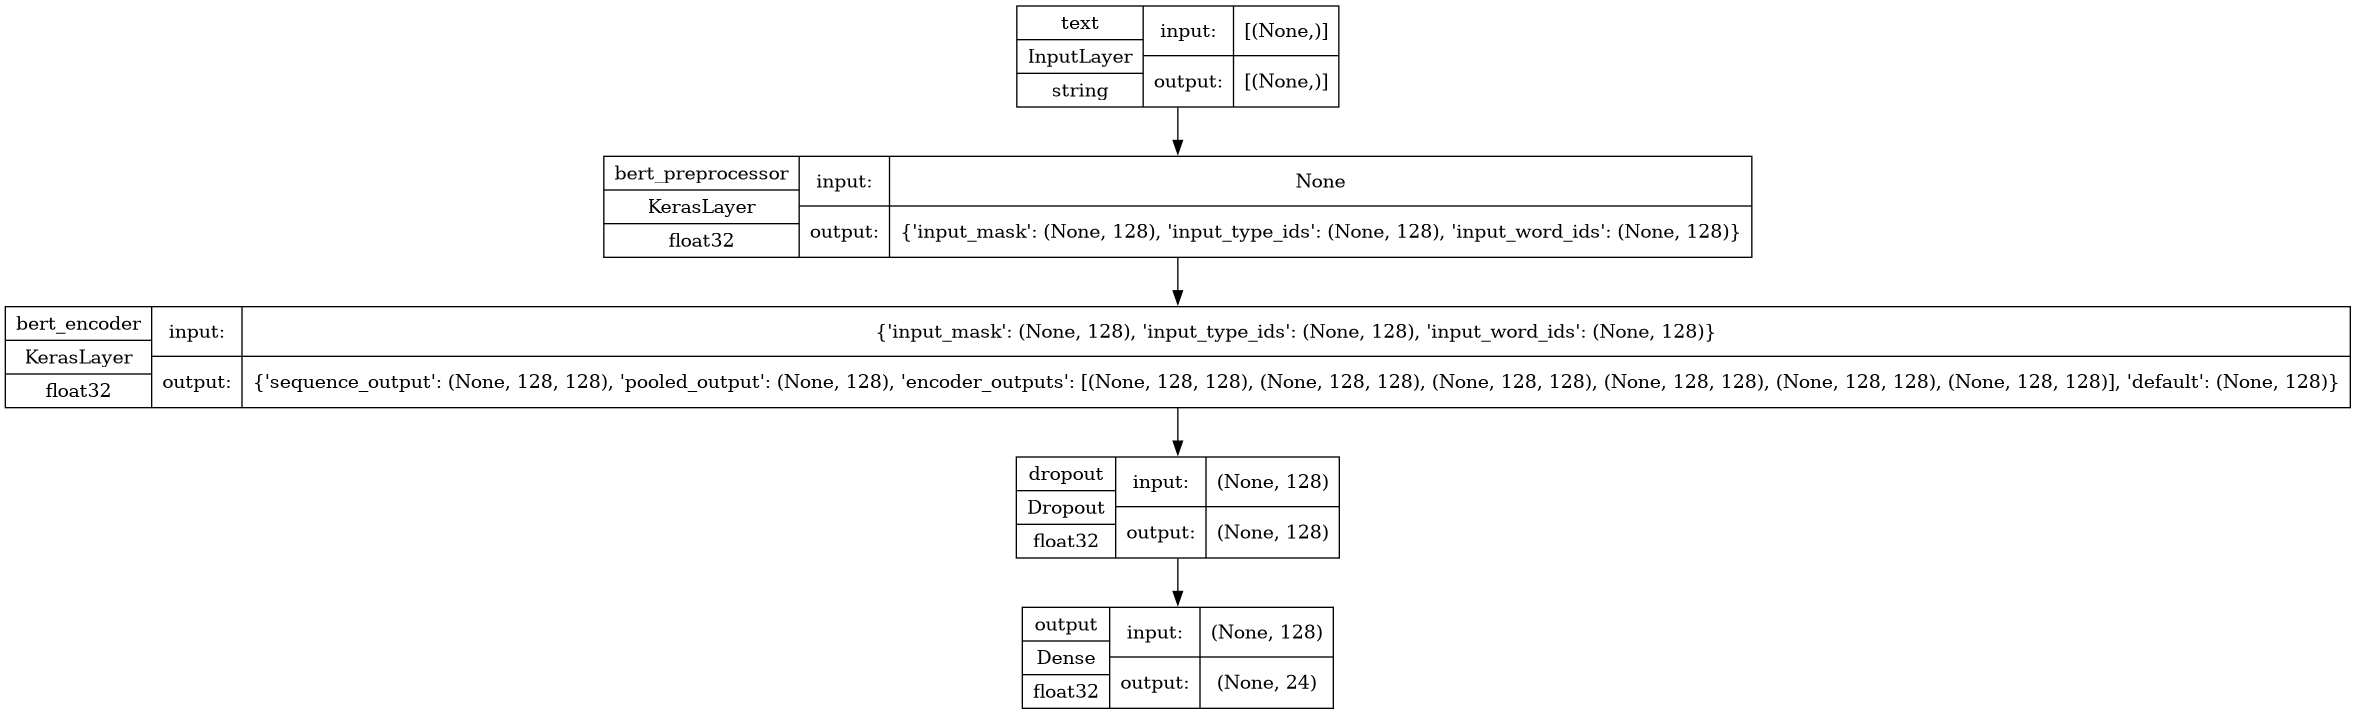

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/8
15/15 [==============================] - 31s 486ms/step - loss: 3.4450 - accuracy: 0.0437 - val_loss: 3.2229 - val_accuracy: 0.0333
Epoch 2/8
15/15 [==============================] - 4s 255ms/step - loss: 3.3126 - accuracy: 0.0458 - val_loss: 3.1968 - val_accuracy: 0.0333
Epoch 3/8
15/15 [==============================] - 4s 264ms/step - loss: 3.1104 - accuracy: 0.0979 - val_loss: 2.7396 - val_accuracy: 0.1083
Epoch 4/8
15/15 [==============================] - 4s 256ms/step - loss: 2.4726 - accuracy: 0.2490 - val_loss: 1.9918 - val_accuracy: 0.3458
Epoch 5/8
15/15 [==============================] - 4s 252ms/step - loss: 1.7018 - accuracy: 0.4979 - val_loss: 1.2933 - val_accuracy: 0.5958
Epoch 6/8
15/15 [==============================] - 4s 252ms/step - loss: 0.9994 - accuracy: 0.7333 - val_loss: 0.7652 - val_accuracy: 0.7917
Epoch 7/8
15/15 [==============================] - 4s 254ms/step - loss: 0.5668 - accuracy: 0.8656 - val_loss: 0.4950 - val_accuracy: 0.8625
Epoch 8/8
15

# Saving the model and the classes

We now save our model in ```.keras``` format and the classes dictionary in ```.json``` format.

Save Model in Keras Format:
The model.save method is used to save the trained model in Keras format. The saved model will be in the HDF5 file format and will include the architecture, weights, and optimizer state.

Save Classes to JSON:
The code extracts the classes from the label binarizer (label_binarizer.classes_).
It creates a dictionary (classes_dict) with the class indices as keys and class names as values.
The dictionary is then saved to a JSON file (classes.json) using json.dump.

In [ ]:
model.save('/kaggle/working/model.keras')

In [ ]:
classes = label_binarizer.classes_
classes_dict = {i: v for i, v in enumerate(classes)}
with open('/kaggle/working/classes.json', 'w') as file:
    json.dump(classes_dict, file)

# Testing our Model

We now test our model using some custom inputs to check its predictions.

## The predict function

The predict function here takes text as a parameter which is the string containing the user prompt. It then creates a dictionary with a key ```text``` and the value as the entered prompt. We then convert the entered prompt into a tensor so that our model can predict the class. We finally use the ```predict``` function of our model to predict the probability (the softmax function) of all our classes and we return the top three classes with the highest probability.

Takes a text input.
Prepares the input feature.
Converts the feature to a TensorFlow tensor.
Makes predictions using the model.
Creates a dictionary mapping predicted diseases to their confidence scores.
Sorts the dictionary by confidence scores in descending order.
Prints the top three predicted diseases and their confidence scores.

In [ ]:
def predict(text):
    print(text)
    feature = {'text': text}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)[0]
    classes = label_binarizer.classes_
    predictions_dict = {}
    for i in range(len(classes)):
        predictions_dict[classes[i]] = predictions[i] * 100
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}
    count = 0
    for disease in predictions_dict:
        if count == 3:
            break
        print(f'{disease}: {predictions_dict[disease]}%')
        count += 1

In [ ]:
predict('I inadvertently lose weight and have a hard time gaining it back. I use antacids to get rid of the pain and discomfort I experience. It aches so much in my mouth.')
print()
predict('My vision is foggy, and it appears to be growing worse. I feel exhausted and worn out all the time. I also have severe dizziness and lightheadedness on occasion.')
print()
predict('I get wheezing and breathing difficulties, which are asthma symptoms. I frequently have headaches and fever. I am continuously exhausted.')

I inadvertently lose weight and have a hard time gaining it back. I use antacids to get rid of the pain and discomfort I experience. It aches so much in my mouth.
Peptic Ulcer Disease: 80.98665475845337%
Diabetes: 10.148701071739197%
Varicose Veins: 2.450842969119549%

My vision is foggy, and it appears to be growing worse. I feel exhausted and worn out all the time. I also have severe dizziness and lightheadedness on occasion.
Diabetes: 86.90938949584961%
Drug Reaction: 4.16480228304863%
Peptic Ulcer Disease: 4.129981622099876%

I get wheezing and breathing difficulties, which are asthma symptoms. I frequently have headaches and fever. I am continuously exhausted.
Allergy: 72.44563698768616%
Drug Reaction: 18.635402619838715%
Diabetes: 3.1848005950450897%


In [ ]:
predict('my hands are paining')
print()

my hands are paining
Diabetes: 67.55151748657227%
Drug Reaction: 18.92620176076889%
Dengue: 5.092855915427208%



In [ ]:
# Save the model in the SavedModel format
model.save('/kaggle/working/model_saved_model')


## Graphical User Interface

Load Saved Model:
The code loads a saved TensorFlow model from the specified path.

Define Keras Model:
The code defines a new Keras Sequential model using the loaded inference function. It uses a Lambda layer with the loaded inference function and specifies the input shape and dtype.

Load Classes:
The code loads a dictionary of classes from a JSON file.

Create Widgets:
Text input widget (text_input): A textarea widget for entering symptoms.
Button widget (predict_button): A button for triggering predictions.
Output widget (output): An output widget for displaying predictions.

Button Click Event:
The on_predict_button_click function is called when the button is clicked.
It retrieves the entered symptoms from the text input, gets predictions using the get_prediction function, and prints the top predictions.

Prediction Function (get_prediction):
The get_prediction function uses the model's predict method to get predictions for the entered symptoms.
It converts predictions to a dictionary and sorts them by probability in descending order.
The function returns the top three predictions as a list.

Display Widgets:
The text input, button, and output widgets are displayed.

In [ ]:
# Load the saved model
loaded_model = tf.saved_model.load('/kaggle/working/model_saved_model')

# Get the inference function from the model's signatures
inference_function = loaded_model.signatures["serving_default"]

# Define a new Keras model using the loaded function
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string, name='text'),  # Adjust the input shape and dtype accordingly
    tf.keras.layers.Lambda(inference_function, input_shape=(), dtype=tf.float32)
])

# Load the classes
with open('/kaggle/working/classes.json', 'r') as file:
    classes_dict = json.load(file)
    classes = {int(k): v for k, v in classes_dict.items()}

# Text input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter your symptoms...',
    description='Symptoms:',
    disabled=False
)

# Button widget
predict_button = widgets.Button(description='Predict')

# Output widget
output = widgets.Output()

# Function to be called when the button is clicked
def on_predict_button_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        prediction = get_prediction(text)
        print(f"Entered symptoms: {text}")
        print("\nTop Predictions:")
        for pred in prediction:
            print(f"{pred[0]}: {pred[1]:.2f}%")

# Assign the function to the button click event
predict_button.on_click(on_predict_button_click)

# Function to get predictions
def get_prediction(text):
    # Use the model's predict method to get the dictionary of predictions
    predictions_dict = model.predict(tf.constant([text]))

    # Convert predictions to a dictionary
    predictions_dict = {classes[i]: predictions_dict['output'][0][i] * 100 for i in range(len(classes))}

    # Sort predictions by probability in descending order
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}

    # Return the top three predictions
    top_predictions = list(predictions_dict.items())[:3]

    return top_predictions


# Display widgets
display(text_input)
display(predict_button)
display(output)


Textarea(value='', description='Symptoms:', placeholder='Enter your symptoms...')

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
# Load the saved model
loaded_model = tf.saved_model.load('/kaggle/working/model_saved_model')

# Get the inference function from the model's signatures
inference_function = loaded_model.signatures["serving_default"]

# Define a new Keras model using the loaded function
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string, name='text'),  # Adjust the input shape and dtype accordingly
    tf.keras.layers.Lambda(inference_function, input_shape=(), dtype=tf.float32)
])

# Load the classes
with open('/kaggle/working/classes.json', 'r') as file:
    classes_dict = json.load(file)
    classes = {int(k): v for k, v in classes_dict.items()}

# Text input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter your symptoms...',
    description='Symptoms:',
    disabled=False
)

# Button widget
predict_button = widgets.Button(description='Predict')

# Output widget
output = widgets.Output()

# Function to be called when the button is clicked
def on_predict_button_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        prediction = get_prediction(text)
        print(f"Entered symptoms: {text}")
        print("\nTop Predictions:")
        for pred in prediction:
            print(f"{pred[0]}: {pred[1]:.2f}%")

# Assign the function to the button click event
predict_button.on_click(on_predict_button_click)

# Function to get predictions
def get_prediction(text):
    # Use the model's predict method to get the dictionary of predictions
    predictions_dict = model.predict(tf.constant([text]))

    # Convert predictions to a dictionary
    predictions_dict = {classes[i]: predictions_dict['output'][0][i] * 100 for i in range(len(classes))}

    # Sort predictions by probability in descending order
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}

    # Return the top three predictions
    top_predictions = list(predictions_dict.items())[:3]

    return top_predictions


# Display widgets
display(text_input)
display(predict_button)
display(output)


Textarea(value='', description='Symptoms:', placeholder='Enter your symptoms...')

Button(description='Predict', style=ButtonStyle())

Output()